<a href="https://colab.research.google.com/github/KabaTubare/KabaTubare/blob/main/clone_15_update_09032024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gradio librosa xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 66.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.1/92.1 kB 13.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.7/310.7 kB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.5/138.5 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 81.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 10.9 MB/s eta 0:00:00
  Created wheel for ffmpy: filename=ffmpy-0.3.2-py3-none-any.whl s

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
import io
import os
import librosa
import joblib
import gradio as gr
import warnings
warnings.filterwarnings('ignore')
import xgboost as xgb



Saving DATASET-balanced.csv to DATASET-balanced.csv
DATASET-balanced.csv loaded successfully.


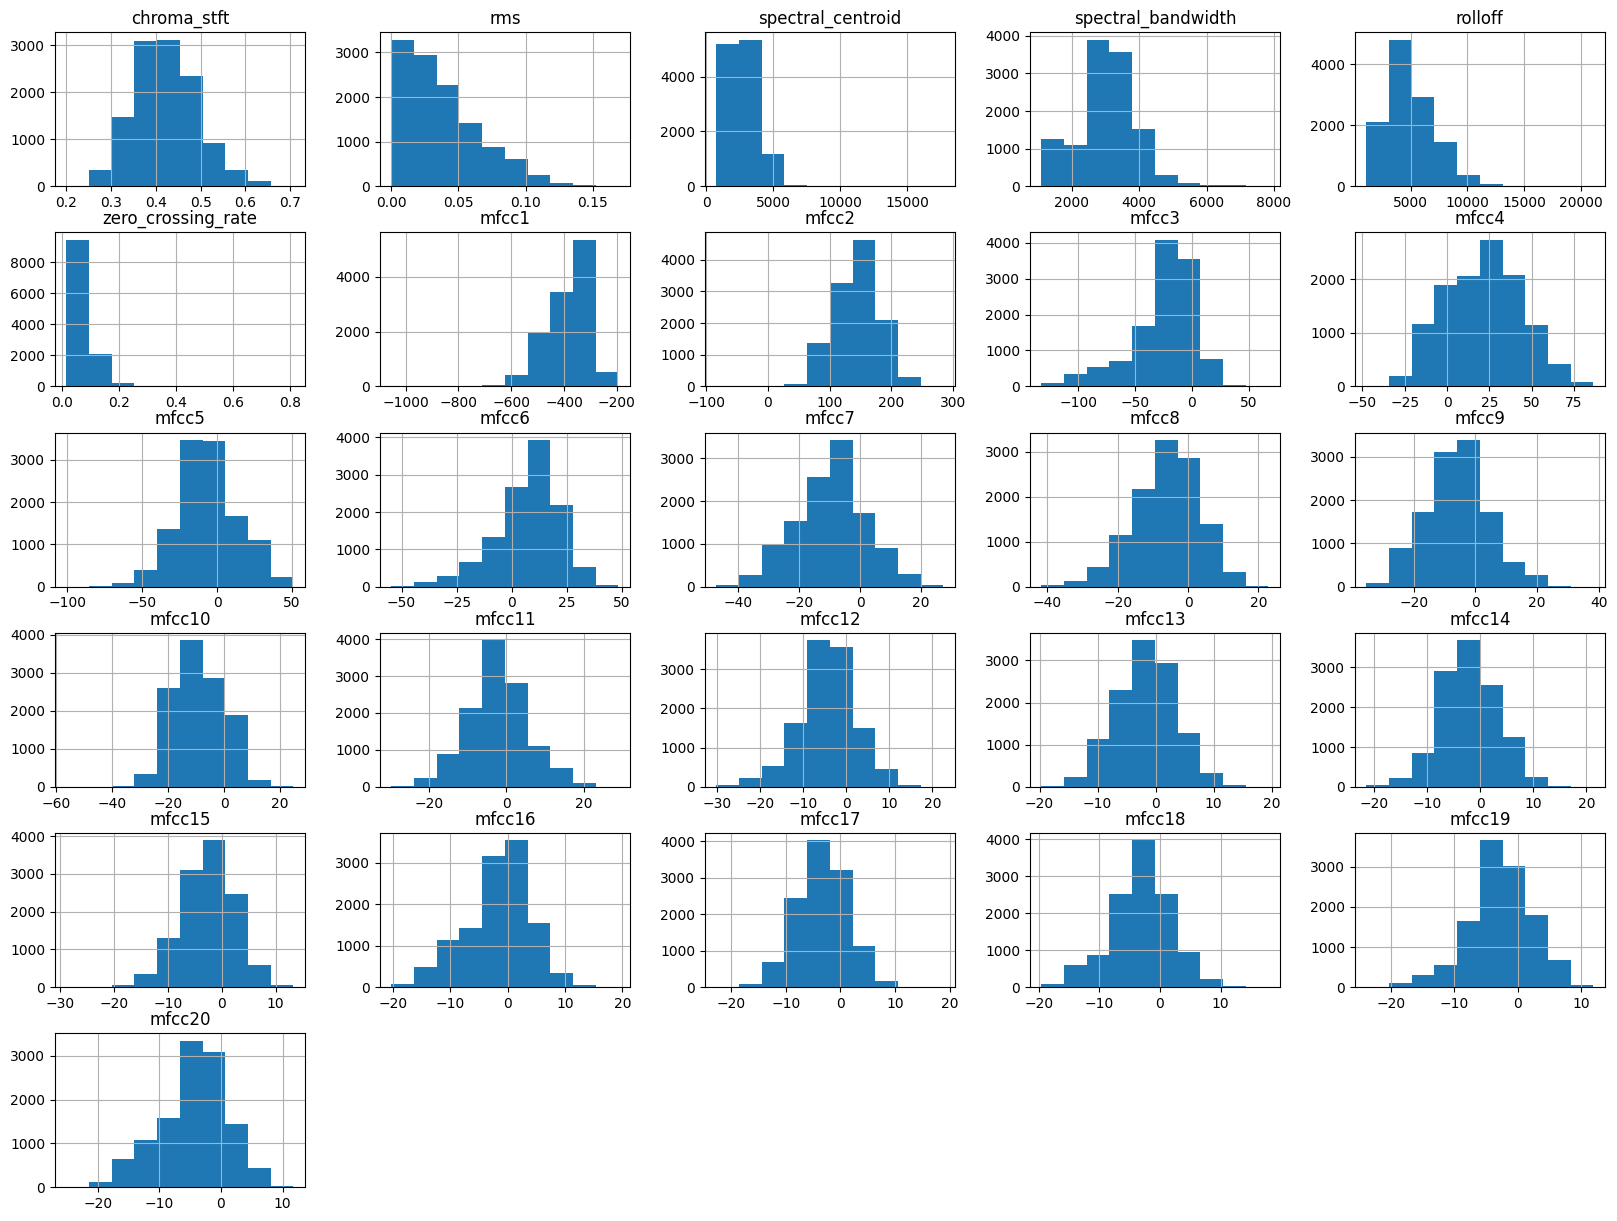

In [3]:
from google.colab import files

uploaded = files.upload()

if 'DATASET-balanced.csv' in uploaded:
    df = pd.read_csv(io.BytesIO(uploaded['DATASET-balanced.csv']))
    print('DATASET-balanced.csv loaded successfully.')
else:
    print('DATASET-balanced.csv not found in uploaded files.')

fake_audio_dir = '/content/drive/MyDrive/Deep_voice_dataset/archive/KAGGLE/AUDIO/FAKE'
real_audio_dir = '/content/drive/MyDrive/Deep_voice_dataset/archive/KAGGLE/AUDIO/REAL'
demonstration_audio_dir = '/content/drive/MyDrive/Deep_voice_dataset/archive/DEMONSTRATION'

df.describe()
df.hist(figsize=(20, 15))
plt.show()

In [4]:
def remove_low_variance_features(X, threshold=0.01):
    selector = VarianceThreshold(threshold)
    selector.fit(X)
    return X[X.columns[selector.get_support(indices=True)]]

def remove_highly_correlated_features(X, threshold=0.8):
    corr_matrix = X.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    return X.drop(to_drop, axis=1)

def train_models(df):
    X = df.drop('LABEL', axis=1)
    y = df['LABEL']

    # Encode string labels to numerical labels
    le = LabelEncoder()
    y = le.fit_transform(y)

    X_selected = remove_low_variance_features(X)
    X_selected = remove_highly_correlated_features(X_selected)

    features_order = X_selected.columns.tolist()

    scaler = StandardScaler()
    pca = PCA(n_components=0.95)  # Keep 95% of variance

    pipeline = Pipeline([
        ('scaling', scaler),
        ('pca', pca),
    ])

    X_scaled_pca = pipeline.fit_transform(X_selected)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled_pca, y, test_size=0.2, random_state=42)

    param_grid_log_reg = {
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2']
    }

    param_grid_rf = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30],
        'min_samples_split': [2, 5, 10]
    }

    param_grid_xgb = {
        'max_depth': [3, 5, 7],
        'learning_rate': [0.1, 0.3, 0.5],
        'n_estimators': [50, 100, 150],
        'gamma': [0, 0.1, 0.2]
    }

    grid_search_log_reg = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_log_reg, cv=5, n_jobs=-1)
    grid_search_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=5, n_jobs=-1)
    grid_search_xgb = GridSearchCV(xgb.XGBClassifier(objective='binary:logistic'), param_grid_xgb, cv=5, n_jobs=-1)

    grid_search_log_reg.fit(X_train, y_train)
    grid_search_rf.fit(X_train, y_train)
    grid_search_xgb.fit(X_train, y_train)

    log_reg = grid_search_log_reg.best_estimator_
    random_forest = grid_search_rf.best_estimator_
    xgb_clf = grid_search_xgb.best_estimator_

    voting_clf = VotingClassifier(estimators=[('lr', log_reg), ('rf', random_forest), ('xgb', xgb_clf)], voting='soft')
    voting_clf.fit(X_train, y_train)

    predictions_log_reg = log_reg.predict(X_test)
    predictions_rf = random_forest.predict(X_test)
    predictions_xgb = xgb_clf.predict(X_test)
    predictions_voting = voting_clf.predict(X_test)

    # Inverse transform predictions back to original labels
    predictions_log_reg = le.inverse_transform(predictions_log_reg)
    predictions_rf = le.inverse_transform(predictions_rf)
    predictions_xgb = le.inverse_transform(predictions_xgb)
    predictions_voting = le.inverse_transform(predictions_voting)

    # Transform y_test back to original labels for consistency in reports
    y_test = le.inverse_transform(y_test)

    print("Logistic Regression Model Evaluation")
    print(classification_report(y_test, predictions_log_reg))
    print("Random Forest Classifier Model Evaluation")
    print(classification_report(y_test, predictions_rf))
    print("XGBoost Classifier Model Evaluation")
    print(classification_report(y_test, predictions_xgb))
    print("Voting Classifier Model Evaluation")
    print(classification_report(y_test, predictions_voting))

    model_directory = '/content/drive/MyDrive/Deep_voice_dataset/archive/KAGGLE/AUDIO/Trained_model'
    os.makedirs(model_directory, exist_ok=True)

    joblib.dump(log_reg, os.path.join(model_directory, 'log_reg_model.joblib'))
    joblib.dump(random_forest, os.path.join(model_directory, 'random_forest_model.joblib'))
    joblib.dump(xgb_clf, os.path.join(model_directory, 'xgb_model.joblib'))
    joblib.dump(voting_clf, os.path.join(model_directory, 'voting_clf_model.joblib'))

    log_reg_model = joblib.load(os.path.join(model_directory, 'log_reg_model.joblib'))
    random_forest_model = joblib.load(os.path.join(model_directory, 'random_forest_model.joblib'))
    xgb_model = joblib.load(os.path.join(model_directory, 'xgb_model.joblib'))
    voting_clf_model = joblib.load(os.path.join(model_directory, 'voting_clf_model.joblib'))

    return log_reg_model, random_forest_model, xgb_model, voting_clf_model, features_order, pipeline

In [5]:
def extract_features(audio_path, features_order):
    # Load audio file
    audio, sr = librosa.load(audio_path, sr=None)

    # Extract MFCC features
    mfcc = librosa.feature.mfcc(y=audio, sr=sr)

    # Reshape MFCC features to match the expected shape
    features_df = pd.DataFrame(mfcc.T, columns=features_order)
    return features_df

def predict_voice(audio_path, features_order, pipeline, log_reg_model, random_forest_model, xgb_model, voting_clf_model):
    features_df = extract_features(audio_path, features_order)
    features_df_scaled_pca = pipeline.transform(features_df)

    prediction_log_reg = log_reg_model.predict(features_df_scaled_pca)[0]
    prediction_rf = random_forest_model.predict(features_df_scaled_pca)[0]
    prediction_xgb = xgb_model.predict(features_df_scaled_pca)[0]
    prediction_voting = voting_clf_model.predict(features_df_scaled_pca)[0]

    confidence_log_reg = np.max(log_reg_model.predict_proba(features_df_scaled_pca))
    confidence_rf = np.max(random_forest_model.predict_proba(features_df_scaled_pca))
    confidence_xgb = np.max(xgb_model.predict_proba(features_df_scaled_pca))
    confidence_voting = np.max(voting_clf_model.predict_proba(features_df_scaled_pca))

    # Map numerical labels back to string labels
    label_mapping = {0: 'Fake', 1: 'Real'}
    prediction_log_reg = label_mapping[prediction_log_reg]
    prediction_rf = label_mapping[prediction_rf]
    prediction_xgb = label_mapping[prediction_xgb]
    prediction_voting = label_mapping[prediction_voting]

    return (prediction_log_reg, confidence_log_reg), (prediction_rf, confidence_rf), (prediction_xgb, confidence_xgb), (prediction_voting, confidence_voting)

def predict_demonstration_audios(demonstration_audio_dir, features_order, pipeline, log_reg_model, random_forest_model, xgb_model, voting_clf_model):
    if not os.path.exists(demonstration_audio_dir):
        print("Demonstration directory does not exist.")
        return

    audio_files = [f for f in os.listdir(demonstration_audio_dir) if f.endswith('.wav') or f.endswith('.mp3')]

    for audio_file in audio_files:
        audio_path = os.path.join(demonstration_audio_dir, audio_file)
        (prediction_log_reg, confidence_log_reg), (prediction_rf, confidence_rf), (prediction_xgb, confidence_xgb), (prediction_voting, confidence_voting) = predict_voice(audio_path, features_order, pipeline, log_reg_model, random_forest_model, xgb_model, voting_clf_model)

        print(f"Audio File: {audio_file}")
        print(f"Logistic Regression Prediction: {prediction_log_reg}, Confidence: {confidence_log_reg}")
        print(f"Random Forest Prediction: {prediction_rf}, Confidence: {confidence_rf}")
        print(f"XGBoost Prediction: {prediction_xgb}, Confidence: {confidence_xgb}")
        print(f"Voting Classifier Prediction: {prediction_voting}, Confidence: {confidence_voting}")
        print("-" * 80)

log_reg_model, random_forest_model, xgb_model, voting_clf_model, features_order, pipeline = train_models(df)

Logistic Regression Model Evaluation
              precision    recall  f1-score   support

        FAKE       0.80      0.78      0.79      1193
        REAL       0.78      0.80      0.79      1163

    accuracy                           0.79      2356
   macro avg       0.79      0.79      0.79      2356
weighted avg       0.79      0.79      0.79      2356

Random Forest Classifier Model Evaluation
              precision    recall  f1-score   support

        FAKE       0.98      0.98      0.98      1193
        REAL       0.98      0.98      0.98      1163

    accuracy                           0.98      2356
   macro avg       0.98      0.98      0.98      2356
weighted avg       0.98      0.98      0.98      2356

XGBoost Classifier Model Evaluation
              precision    recall  f1-score   support

        FAKE       0.99      0.98      0.99      1193
        REAL       0.98      0.99      0.99      1163

    accuracy                           0.99      2356
   macro avg 

In [6]:
iface = gr.Interface(
    fn=lambda audio_path: predict_voice(audio_path, features_order, pipeline, log_reg_model, random_forest_model, xgb_model, voting_clf_model),
    inputs=gr.Audio(label="Upload Audio File", type="filepath"),
    outputs=[
        gr.Text(label="Logistic Regression Prediction and Confidence"),
        gr.Text(label="Random Forest Prediction and Confidence"),
        gr.Text(label="XGBoost Prediction and Confidence"),
        gr.Text(label="Voting Classifier Prediction and Confidence")
    ],
    title="Voice Authenticity Detection",
    description="Detects whether a voice is real or AI-generated. Upload an audio file to get started.",
    examples=[["examples/fake.wav"], ["examples/real.wav"]],
    allow_flagging="never",
    theme="huggingface",
    analytics_enabled=False,
    cache_examples=False
)

iface.launch(debug=True, server_port=7860, share=True, inbrowser=True, server_name="0.0.0.0")



Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://1de138b98900e378d4.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 0.0.0.0:7860 <> https://1de138b98900e378d4.gradio.live


In [ ]:
# Add this function to load trained models and pipeline
def load_models(model_directory):
    log_reg_model = joblib.load(os.path.join(model_directory, 'log_reg_model.joblib'))
    random_forest_model = joblib.load(os.path.join(model_directory, 'random_forest_model.joblib'))
    xgb_model = joblib.load(os.path.join(model_directory, 'xgb_model.joblib'))
    voting_clf_model = joblib.load(os.path.join(model_directory, 'voting_clf_model.joblib'))

    features_order = joblib.load(os.path.join(model_directory, 'features_order.joblib'))
    pipeline = joblib.load(os.path.join(model_directory, 'pipeline.joblib'))

    return log_reg_model, random_forest_model, xgb_model, voting_clf_model, features_order, pipeline

model_directory = '/content/drive/MyDrive/Deep_voice_dataset/archive/KAGGLE/AUDIO/Trained_model'

# Check if trained models and pipeline exist, if so, load them; otherwise, train them
if os.path.exists(os.path.join(model_directory, 'log_reg_model.joblib')):
    print("Loading trained models and pipeline...")
    models = load_models(model_directory)
else:
    print("Training models...")
    models = train_models(df)
    joblib.dump(models[-2], os.path.join(model_directory, 'features_order.joblib'))
    joblib.dump(models[-1], os.path.join(model_directory, 'pipeline.joblib'))

log_reg_model, random_forest_model, xgb_model, voting_clf_model, features_order, pipeline = models

# Use the loaded models and pipeline in your Gradio interface
iface = gr.Interface(
    fn=lambda audio_path: predict_voice(audio_path, features_order, pipeline, log_reg_model, random_forest_model, xgb_model, voting_clf_model),
    inputs=gr.Audio(label="Upload Audio File", type="filepath"),
    outputs=[
        gr.Text(label="Logistic Regression Prediction and Confidence"),
        gr.Text(label="Random Forest Prediction and Confidence"),
        gr.Text(label="XGBoost Prediction and Confidence"),
        gr.Text(label="Voting Classifier Prediction and Confidence")
    ],
    title="Voice Authenticity Detection",
    description="Detects whether a voice is real or AI-generated. Upload an audio file to get started.",
    examples=[["examples/fake.wav"], ["examples/real.wav"]],
    allow_flagging="never",
    theme="huggingface",
    analytics_enabled=False,
    cache_examples=False
)

iface.launch(debug=True, server_port=7860, share=True, inbrowser=True, server_name="0.0.0.0")
